In [1]:
import numpy as np
import pandas as pd
import scanpy as sc



In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.7


In [25]:
results_file = 'C:\\Users\\Mujtaba Barci\\Desktop\\Bioimformatics\\bioimformatic project\\Scanpy projects\\results\\'

In [4]:
adata = sc.read_10x_mtx(
    'C:\\Users\\Mujtaba Barci\\Desktop\\Bioimformatics\\bioimformatic project\\Scanpy projects\hg19\\',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache\C-Users-Mujtaba Barci-Desktop-Bioimformatics-bioimformatic project-Scanpy projects-hg19-matrix.h5ad


In [5]:
adata.var_names_make_unique()

In [6]:
adata


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

<b> **Preprocessing:** </b>

normalizing counts per cell
    finished (0:00:00)


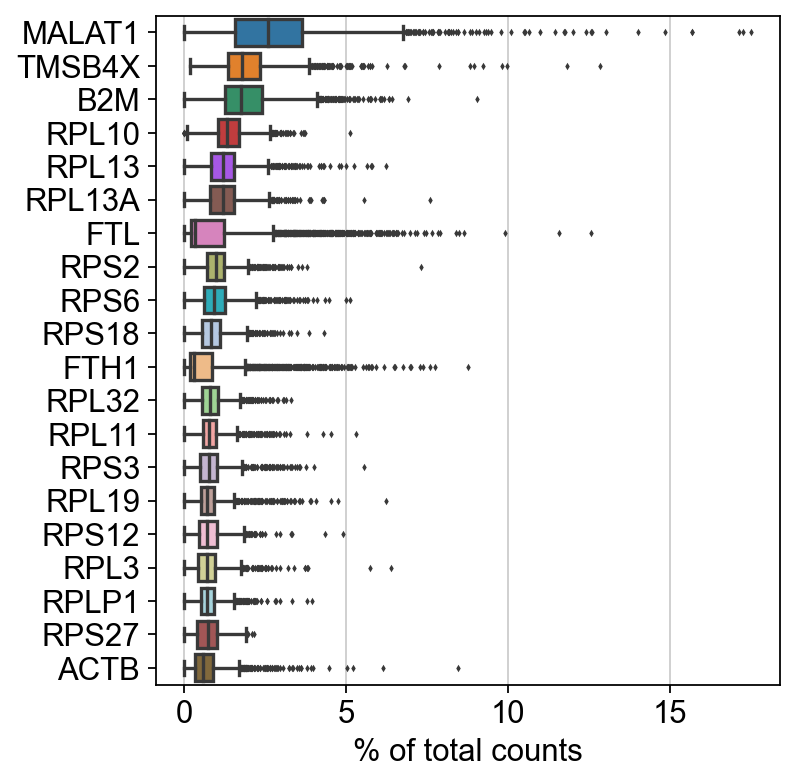

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

Filtering:

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [9]:
#mitochondrial genes filtering
adata.var['mt'] = adata.var_names.str.startswith ('MT-')
sc.pp.calculate_qc_metrics (adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True )

violin plot/cal:
     1.n_genes_by_counts
    2.total_counts
     3.pct_counts_mt


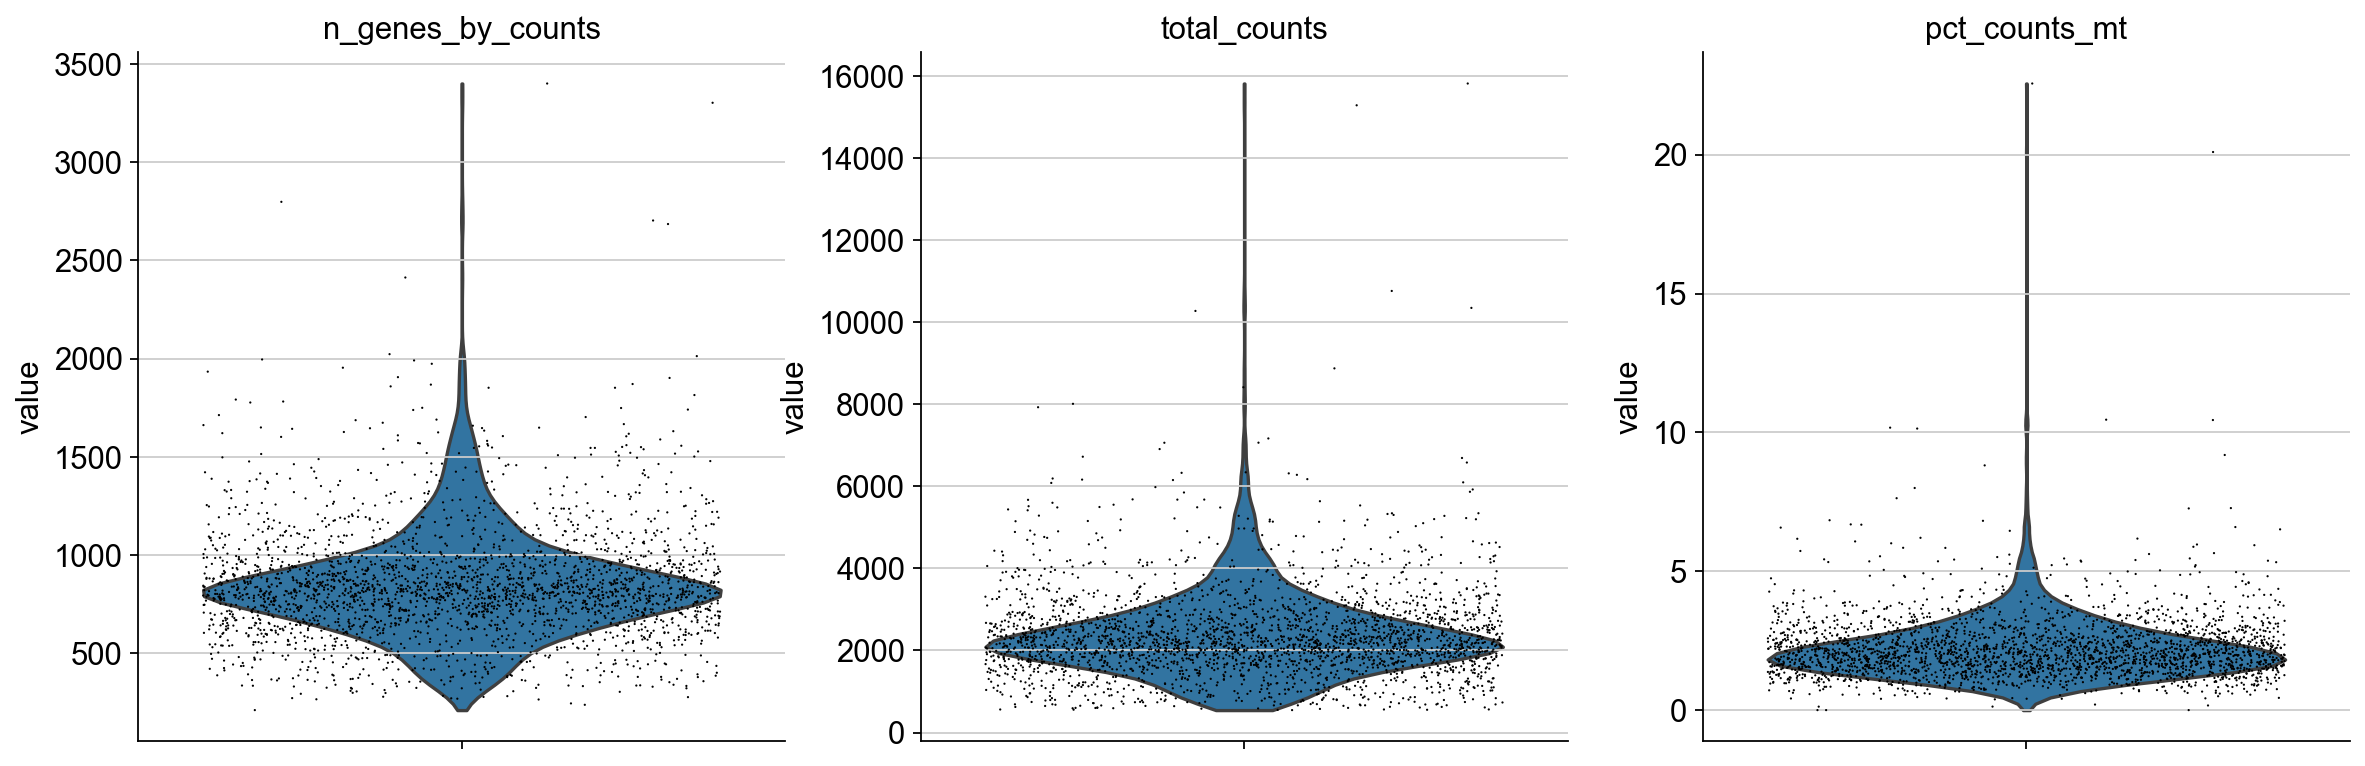

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts:



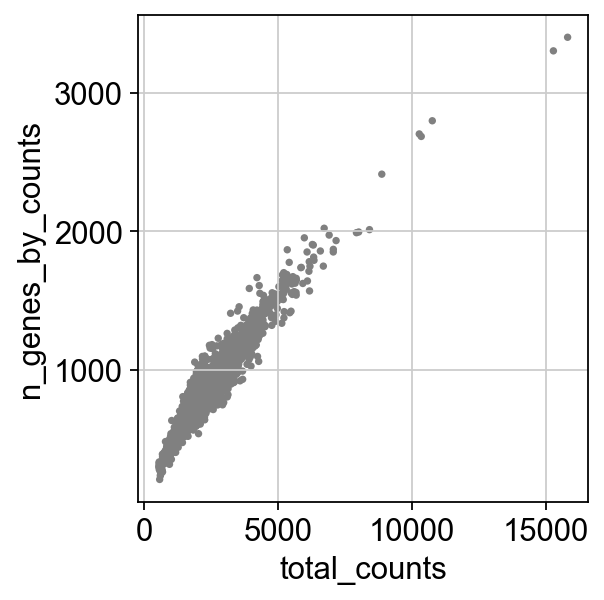

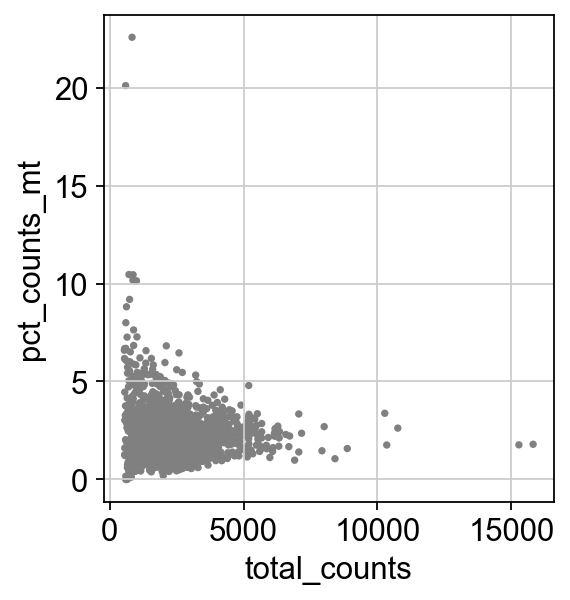

In [11]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

slicing Annadata:


In [12]:
adata = adata[adata.obs.n_genes_by_counts <2500, :]
adata = adata[adata.obs.pct_counts_mt <5, :]

Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, and logarithmize the Data:

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
sc.pp.log1p(adata)

Highly variable gene:

In [15]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


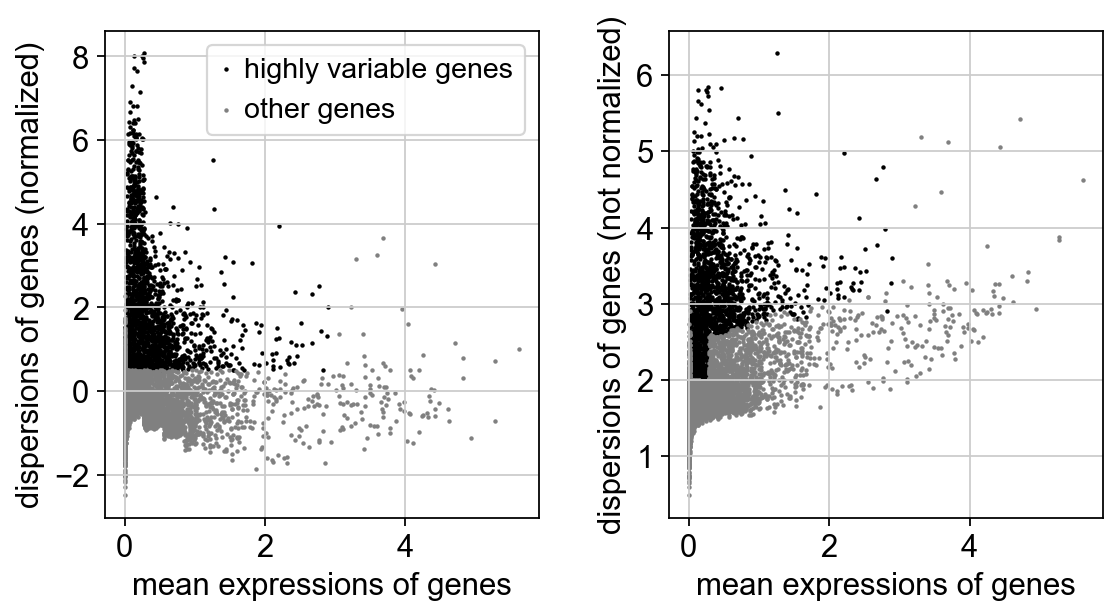

In [16]:
sc.pl.highly_variable_genes(adata)

In [17]:
adata.raw = adata  #.raw attribute of the AnnData object to the normalized and logarithmized raw gene expression

Filtering highly variable gene results:(unnecessary)

In [18]:
adata = adata[:, adata.var.highly_variable]


Regress_out unwanted source of Varitaion:

In [19]:
adata = adata[:, adata.var.highly_variable]

In [20]:
#Scale each gene to unit variance
sc.pp.scale(adata, max_value=10)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Principal component analysis:


In [21]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


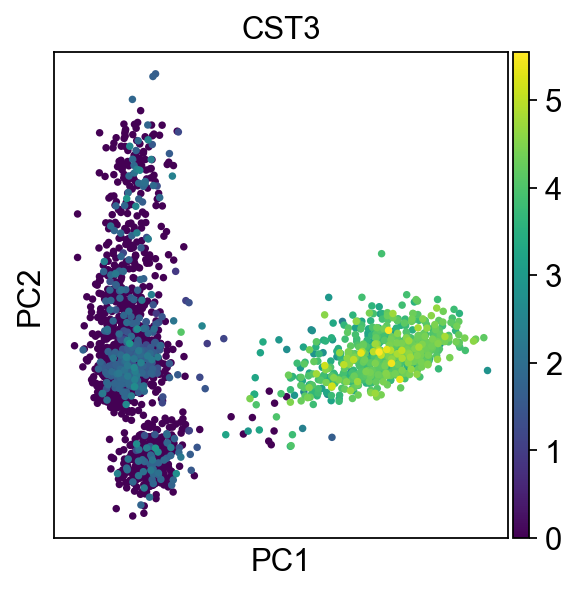

In [22]:
sc.pl.pca(adata, color='CST3')


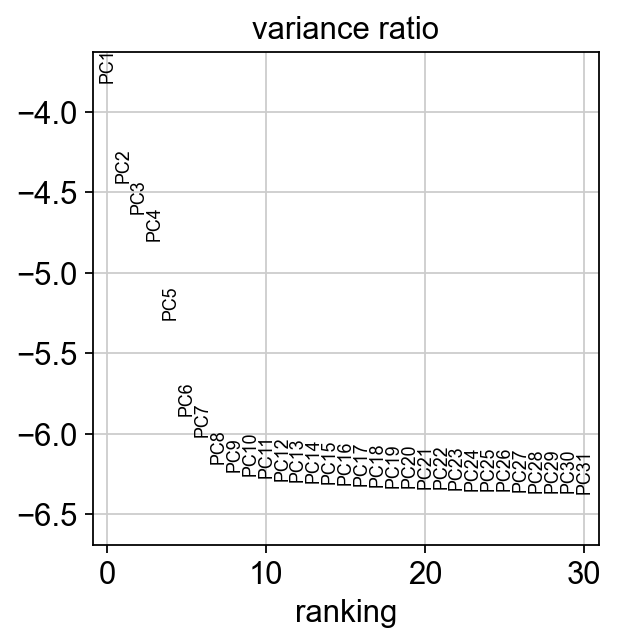

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
adata.write(results_file) #Save the result.




PermissionError: [Errno 13] Unable to create file (unable to open file: name = 'C:\Users\Mujtaba Barci\Desktop\Bioimformatics\bioimformatic project\Scanpy projects', errno = 13, error message = 'Permission denied', flags = 13, o_flags = 302)

### Computing and Embedding the Neighborshood Graph:


In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
sc.tl.umap(adata)


In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])


In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)


### Clustering the neighborhood graph:


In [ ]:
sc.tl.leiden(adata, resolution=0.85)

In [ ]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [ ]:
adata.obs

In [ ]:
adata.write(results_file)

### Finding marker genes:

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

In [ ]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity


In [ ]:
# using wilcoxon 
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata.uns['rank_genes_groups'] ['names'] ['0']

In [ ]:
adata.write(results_file)


In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata = sc.read(results_file)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Get a table with the scores and groups.

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

compare to single cluster.

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
# more deltial about specific group for instance:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=9)

In [ ]:
# reload computed differential expression
adata = sc.read(results_file)


In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)


In [ ]:
# compare certain gene across groups
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

mark the cell types.

In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')


In [ ]:
adata




In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');


In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);


In [ ]:
adata


In [ ]:
adata.write(results_file, compression='gzip')